# **CLASSIFICATION OF FARMING SYSTEMS WITH HARMONICS**
---

Jupyter Notebook for classification of irrigated and rainfed farming systems based on Normalized Difference Vegetation (NDVI) Harmonics, Evapotranspiration (ET), and Landsurface Temperature (LST) data. <br>
The script processes Sentinel-2 time series data in Google Earth Engine, exports tiles and applies a random forest classifier to map farming systems. <br> The following steps will be executed:

1. Create a grid to enable the export of data from Google Earth Engine (GEE) to Google Drive (the tile size is set manually so it doesn't/shouldn't exceed your drive storage). The grid tiles are also needed to process large areas.
2. Connect Jupyter Notebook with GEE, read grid and ROI from your GEE assets.
3. Processes NDVI harmonics from Sentinel-2 time series data directly in GEE.
4. Receive ET and LST from MODIS and NOAA time series data directly in GEE and calculate median ET and maximum LST.
5. Read training data for farming systems from your GEE assets. The training data has to be a shapefile with only one attribute containing the classes 1 for irrigated and 2 for rainfed.
6. Extract pixels from your training data polygons and classify all pixels as either irrigated (1) or rainfed (2).
7. Split training data into 70% training and 30% testing data.
8. Set up random forest classifier training data and use test data for accuracy measurement. The accuracy measures will be exported to your GoogleDrive: check before you continue!
9. Apply final RF Classifier to whole data set of harmonic coefficients, median ET, and maximum LST within your study area to produce Farming Systems product.
10. Mask classification map to only include cropland regions and exclude protected areas within these regions; apply flat areas/slope mask for irrigated land. 
11. Apply majority filter to smoothen the classification result.
12. Download the classification data: Jupyter Notebook connects with your Google Drive (permissions must be given!) and downloads processed Farming Systems tile by tile to prevent problems in Google drive: tile x is exported to your Google Drive, afterwards downloaded to the specified folder on your computer/server and then deleted from your Google Drive (final export will be on your computer).
13. Processing steps to do outside of the Jupyter Notebook: Mosaic exported tiles.

- Author: Maximilian Schwarz (12/2023)
- Method: Landmann T., Eidmann D., Cornish N., Franke J. & Siebert S. (2019): Optimizing harmonics from Landsat time series data: the case of mapping rainfed and irrigated agriculture in Zimbabwe, Remote Sensing Letters, 10:11, 1038-1046, doi:10.1080/2150704X.2019.1648901,   [Access Paper](https://www.tandfonline.com/doi/full/10.1080/2150704X.2019.1648901?scroll=top&needAccess=true  )

#### Preparations before starting Jupyter Notebook
1. For any help: [Conda Cheat Sheet](https://docs.conda.io/projects/conda/en/4.6.0/_downloads/52a95608c49671267e40c689e0bc00ca/conda-cheatsheet.pdf)
2. Start the anaconda prompt and navigate to the folder of your .yml file. 
3. Create a new environment by executing the following code: "conda env create -f kenya_env.yml". Alternatively you don't have to navigate to the folder, but you can adjust the path to the .yml file.
4. Activate new environment: "conda activate kenya_env"
5. Create a kernel for active environment: "python -m ipykernel install --user --name kenya_env --display-name 'kenya_env_kernel'"
5. Open the Jupyter Notebook file (kenya_harmonics.ipynb) and set the kernel to the newly create kernel 'kenya_env_kernel'.
7. Now you have set up the necessary environment to run this script. The only thing missing is the authentication to access google earth engine.

#### Authentification for Google Earth Engine
1. Notebook: 
   - If you execute the following code, you will be redirected to authorize the access needed by Earth Engine. In case you were not redirected, just follow the instructions below the code snippet.

In [1]:
import ee
ee.Authenticate()

Enter verification code:  4/1AdLIrYfoQX6jiIYvIMSAfi4WNu_MULLt6YG3eHKIxxsyN-MBumTO_8QkcU8



Successfully saved authorization token.


2. Notebook Authenticator
   - 2.1 Verify that the correct user account is listed.
   - 2.2 Select a Google Cloud Project to use for Authentication. If you need to create a new project, we recommend the naming convention "ee-xyz" where xyz is your usual Earth Engine user name. (If you cannot select or create a Cloud Project, see the troubleshooting section below.)
   - 2.3 Click Generate Token.
3. Account Selection
   - You will be shown an account selection page. Click on the user account that you want to grant access from the notebook.
4. Warning Page
   - A warning page is presented, indicating that Google did not create the app (i.e. the Colab code in the notebook). Click Continue to acknowledge.
5. Consent Screen
   - Indicate if you are willing to grant the requested scopes and click Continue
6. Authorization Code Screen
   - Copy the authorization verification code/token.
7. Notebook
   - Switch back to the Colab tab, and paste the verification code/token into the code cell output. The cell output should indicate "Successfully saved authorization token." 
   
Congrats. Now you are completely set up to run this script! **IMPORTANT: You have to repeat this process every week.**
If it didn't work and you still have problems, you can find further help in the authentication section of the following website: [Python Installation](https://developers.google.com/earth-engine/guides/python_install)

## Why Harmonics for the Classification of Farming Systems?
---

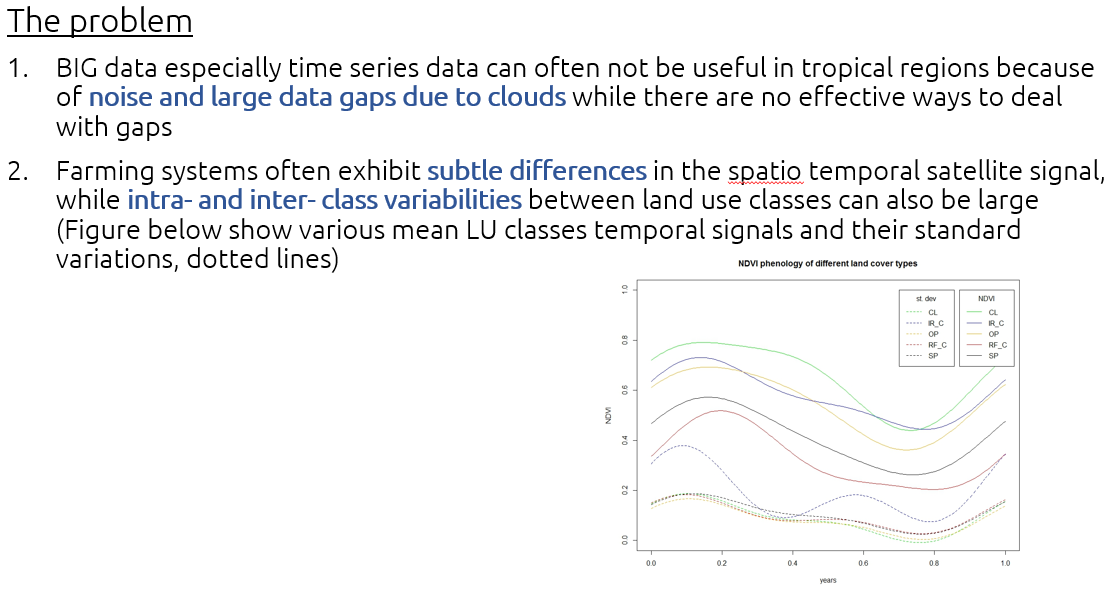

### The Issue of Data Gaps and Noise in long Time Series
---

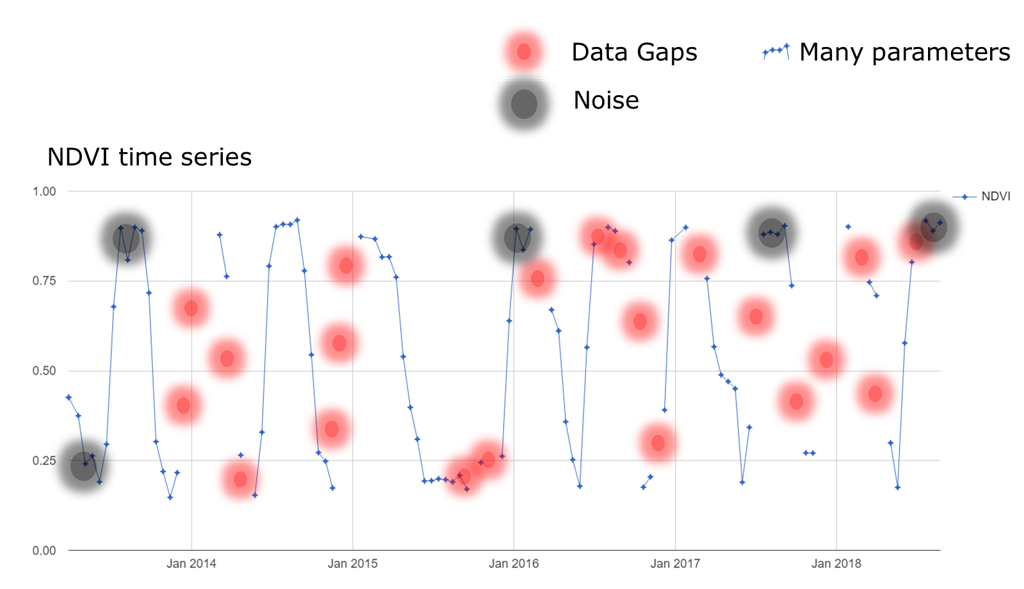

### Harmonic Fitting solves that Problem
---

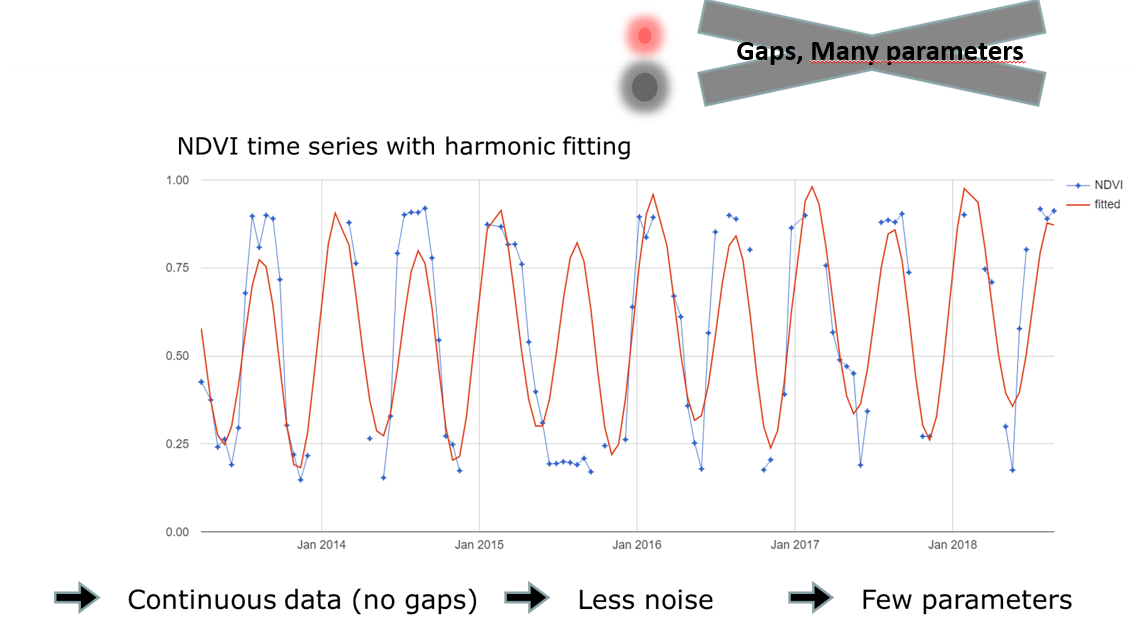

### Example of a Classification Result based on Harmonics
---

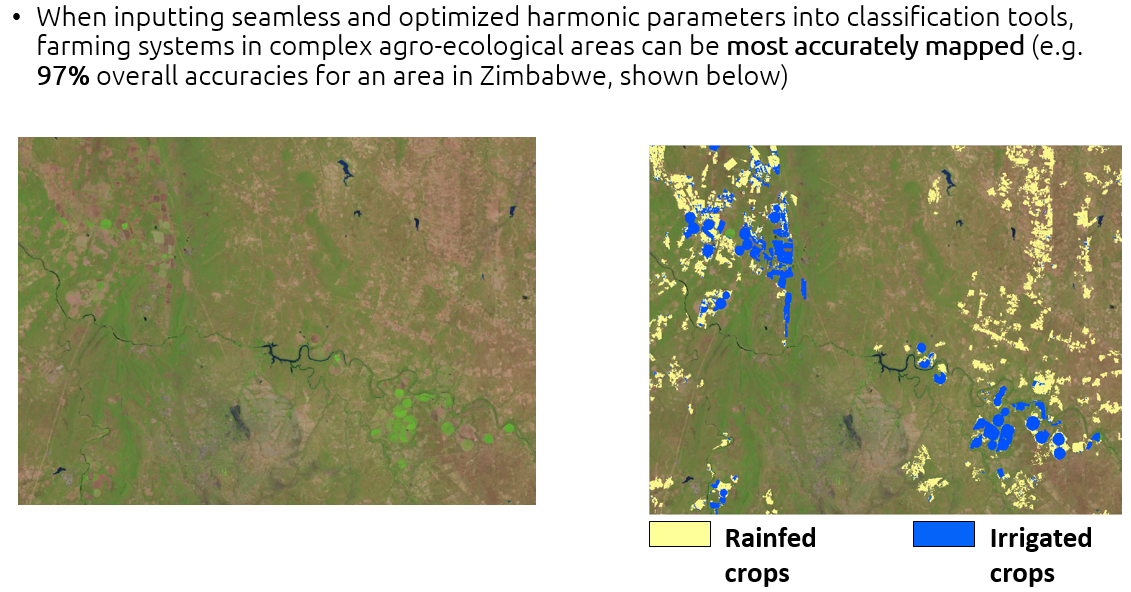

### Basic Principle of Harmonic for Time Series Data
---

The harmonic modeling of the time series data involves fitting a combination of sine and cosine functions to the observed temporal patterns, aiming to characterize seasonal changes in the spectral behavior by decomposing the time series into harmonic terms. Similar to principle component analysis, the majority of the variance in a dataset is contained in the first few terms (components). In our case, amplitude and phase were extracted and used for further analysis. The amplitude corresponds to half the value at which the function is maximized, while the phase is the displacement between the origin and the peak of the wave in a range of 0 to 2π. Each harmonic term represents the number of cycles completed by a wave, in a given time interval, and is responsible for a percentage of the total variance of the original time series. </br>
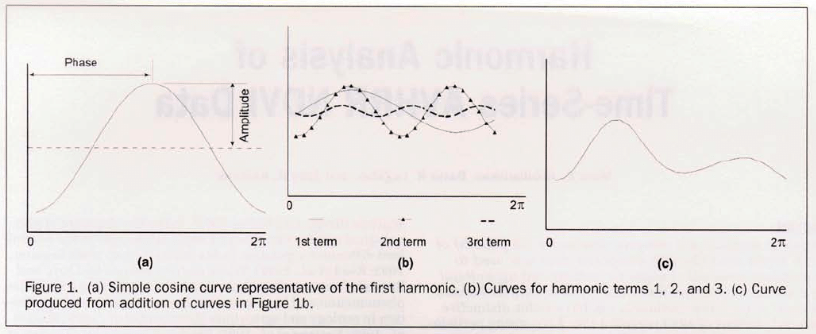
</br>
Source: Jakubauskas, M.E.; Legates, D.R.; Kastens, J.H. (2001). Harmonic analysis of time-series AVHRR NDVI data. PEandRS, Photogrammetric Engineering and Remote Sensing 67(4): 461-470 https://eurekamag.com/research/003/461/003461377.php

---
#### *Start of processing*
---

## *Create Grid for Export*

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

In [3]:
#Read shapefile with ROI from your computer
roi = gpd.read_file('X:/Projekte/22-11 - ADMKenya/03-Vector/Kenya_Shape_files/Updated Kenya Boundary/Kenya_Outline_New.shp')

In [4]:
#Reproject ROI to UTM that best fits (change EPSG)
roi_utm = roi.to_crs({'init': 'epsg:32737'})

C:\Users\schwarz\AppData\Local\anaconda3\envs\kenya_env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
xmin,ymin,xmax,ymax = roi_utm.total_bounds

### *Create Grid with 200km Grid Size*
The grid is necessary for downloading the data from your Google Drive. To create the grid, 200km are added to ymax to cover the whole study area. This is done by adding one row of pixels to the top of the grid.

In [6]:
#Add one row on top to cover whole study area
ymax = ymax + 200000

#### *Set Pixel Size of Grid Cells, and overlapping Area between the Tiles*

In [7]:
#Set pixel size of grid cells
length = 200000
wide = 200000
overlap = 10000

#### *Create Grid*

In [8]:
#Create columns and rows of grid
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

In [9]:
#Create grid from columns and rows
polygons = []
for x in cols:
    for y in rows:
        polygons.append(Polygon([(x-overlap,y+overlap), (x+wide+overlap, y+overlap), (x+wide+overlap, y-length-overlap), (x-overlap, y-length-overlap)]))

#### *Convert Grid to Geodataframe and convert to WGS*

In [10]:
#Convert grid to Geodataframe
grid = gpd.GeoDataFrame({'geometry':polygons})

In [11]:
#Define grid projection
grid.crs = {'init': 'epsg:32737'}

In [12]:
#Convert grid back to WGS
grid_wgs = grid.to_crs({'init': 'epsg:4326'})

C:\Users\schwarz\AppData\Local\anaconda3\envs\kenya_env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### *Export Grid to your Computer*

In [13]:
#Write grid to shapefile
grid_wgs.to_file('X:/Projekte/22-11 - ADMKenya/03-Vector/Kenya_Shape_files/Updated Kenya Boundary/kenya_grid200km.shp')

*Important:* Upload grid and ROI file into GEE assets before you continue!

*Example of produced grid:*

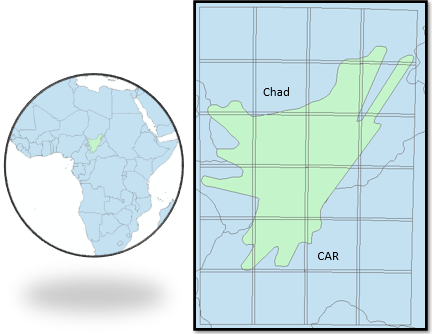

---
## *Start Google Earth Engine*
---

In [14]:
import ee
ee.Initialize()

In [15]:
from geetools import batch
import math

### *Import Data and define Variables*
---

#### *Read Area of Interest from GEE Assets*

In [22]:
#Import shapefile of ROI and grid
#Note: The previously used shapefile and created grid have to be uploaded and stored to your GEE assets
roi = ee.FeatureCollection('projects/ee-mschwarz/assets/kenya_roi') 
grid = ee.FeatureCollection('projects/ee-mschwarz/assets/kenya_grid200km')

#### *Set Time-Range and Number of Cycles per Year to model (Harmonics)*

In [23]:
#Set time range
start = ee.Date('2021-01-01')
end = ee.Date('2023-12-31')
startyr = start.get("year")
endyr = end.get("year")
years = ee.List.sequence(2021,2023)

In [24]:
#Set number of cycles per year to model
harmonics = 3

#### *Load Image Collection for S2 Data and filter Clouds, Time and ROI*

In [25]:
#Define function for cloud mask using the Sentinel-2 QA band
def mask2clouds(image):
    qa = image.select('QA60')
    
    #Bits 10 and 11 are clouds and cirrus
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)
    
    #Both flags set to zero indicates clear conditions
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    #Return masked data
    return image.updateMask(mask).divide(10000).select("B.*").copyProperties(image,  ["system:time_start"])

In [26]:
#Load S2 collection within the set time range and roi
s2_collection = ee.ImageCollection('COPERNICUS/S2')\
                    .filterDate(start, end)\
                    .filterBounds(roi)

In [27]:
#Apply cloud mask to S2 collection
s2_collection = s2_collection.map(mask2clouds)

#### *Load Image Collection for MODIS Evapotranspiration (ET) Data*

In [28]:
#Load collection of MODIS Terra ET (MOD16A2.061) within the set time range and roi
ET = ee.ImageCollection('MODIS/061/MOD16A2')\
         .select('ET')\
         .filter(ee.Filter.date(start, end))\
         .filterBounds(roi)

#### *Load Image Collection for NOAA Landsurface Temperature (LST) Data*

In [29]:
#Load collection of NOAA VIIRS LST VNP21A1D within the set time range and roi
LST = ee.ImageCollection('NOAA/VIIRS/001/VNP21A1D')\
          .select('LST_1KM')\
          .filterDate(start, end)\
          .filterBounds(roi)

#### *Define Dependents and Indepents for the Model*

In [30]:
#Dependent variable in the model
dependent_NDVI = ['NDVI']
dependent_ET = ['ET']
dependent_LST = ['LST_1KM']

In [31]:
#Create list of harmonic frequencies to model (also serve as band names)
harmonicFrequencies =  list(range(1, harmonics+1))

In [32]:
#Function to get a sequence of band names for harmonic terms
cosNames_NDVI = [f'cos_NDVI{i}' for i in range(1, harmonics+1)]
sinNames_NDVI = [f'sin_NDVI{i}' for i in range(1, harmonics+1)]

In [33]:
#Independent variables
independents_NDVI = ['constant_NDVI', 't_NDVI'] + cosNames_NDVI + sinNames_NDVI

### *Compute NDVI Harmonics*
---

#### *Compute and add Bands: NDVI, Time in Radians, cos/sin/time for Harmonics*

In [34]:
#Function to add NDVI band
def addNDVI(image):
    return image \
        .addBands(image.normalizedDifference(['B8', 'B4'])\
        .rename('NDVI'))\
        .float()

In [35]:
#Function to add a time band in radians
def addDependents(image, variable):
    years = image.date().difference('2019-01-01', 'year')
    timeRadians = ee.Image(years.multiply(2*math.pi)).rename(f't_{variable}')
    constant = ee.Image(1).rename(f'constant_{variable}')
    return image.addBands(constant).addBands(timeRadians.float())

In [36]:
#Function to compute specified number of harmonics and add them as bands (assumes time band is present)
def addHarmonics(image, variable, cosNames, sinNames):
    frequencies = ee.Image.constant(harmonicFrequencies)
    time = ee.Image(image).select(f't_{variable}')
    cosines = time.multiply(frequencies).cos().rename(cosNames)
    sines = time.multiply(frequencies).sin().rename(sinNames)
    return image.addBands(cosines).addBands(sines)

In [37]:
#Filter ROI and add variables
harmonic_NDVI = s2_collection.filterBounds(roi)
harmonic_NDVI = harmonic_NDVI.map(addNDVI)
harmonic_NDVI = harmonic_NDVI.map(lambda image: addDependents(image, 'NDVI'))
harmonic_NDVI = harmonic_NDVI.map(lambda image: addHarmonics(image, 'NDVI', cosNames_NDVI, sinNames_NDVI))

#### *Compute Trend for Harmonics*

In [38]:
#Output of the regression reduction is a 4x1 array image
indep_dep_NDVI = independents_NDVI + dependent_NDVI

harmonicTrend_NDVI = harmonic_NDVI.select(indep_dep_NDVI)\
    .reduce(ee.Reducer.linearRegression(len(indep_dep_NDVI)-1, 1))

In [39]:
#Turn the array image into a multi-band image of coefficients
harmonicTrendCoefficients_NDVI = harmonicTrend_NDVI.select('coefficients').arrayProject([0]).arrayFlatten([independents_NDVI])

#### *Compute Fitted Values and Coefficients of Harmonics*

In [40]:
#Define function to compute fitted values
def fitharmonics(image, independents, harmonicTrendCoefficients):
    return image.addBands(image.select(independents).multiply(harmonicTrendCoefficients).reduce('sum').rename('fitted'))

#Apply the function
fittedHarmonic_NDVI = harmonic_NDVI.map(lambda image: fitharmonics(image, independents_NDVI, harmonicTrendCoefficients_NDVI))

In [41]:
#Create layer names for amplitude and phase
amplitude_names_NDVI = [f'amp_NDVI{i}' for i in range(1, harmonics+1)]
phase_names_NDVI = [f'phase_NDVI{i}' for i in range(1, harmonics+1)]

In [42]:
#Define function to calculate amplitude and phase
def calculateCoeffs(img, freqs, cosNames, sinNames, ampNames, phaseNames, variable):
    phase = img.select(cosNames).atan2(img.select(sinNames)).rename(phaseNames)
    amplitude = img.select(cosNames).hypot(img.select(sinNames)).rename(ampNames)
    return img.select([f'constant_{variable}', f't_{variable}']).addBands(phase.addBands(amplitude))

In [43]:
#Apply function to calculate amplitude/ phase and create an image with harmonic coefficients
coeffs = calculateCoeffs(harmonicTrendCoefficients_NDVI, harmonicFrequencies, cosNames_NDVI, sinNames_NDVI, amplitude_names_NDVI, phase_names_NDVI, 'NDVI')

In [44]:
#Check NDVI Band names
coeffs.bandNames().getInfo()

['constant_NDVI',
 't_NDVI',
 'phase_NDVI1',
 'phase_NDVI2',
 'phase_NDVI3',
 'amp_NDVI1',
 'amp_NDVI2',
 'amp_NDVI3']

#### *RGB-Example of harmonics coefficients:*

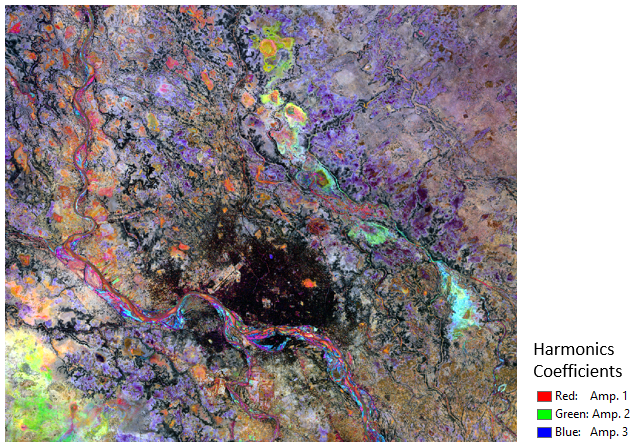

### *Compute median ET and max LST*
---

#### *Compute and add Bands: median ET and max LST*

In [45]:
#Function to compute mean ET and max LST and add Bands
def addET_LST(ET, LST, image):
    ET_median = ET.median().clip(roi).rename('ET_median')
    LST_max = LST.max().clip(roi).rename('LST_max')
    return image.addBands(ET_median).addBands(LST_max)

In [46]:
#Add climate variables as bands to the harmonics coefficients
coeffs = addET_LST(ET, LST, coeffs)

In [47]:
#Check band names
coeffs.bandNames().getInfo()

['constant_NDVI',
 't_NDVI',
 'phase_NDVI1',
 'phase_NDVI2',
 'phase_NDVI3',
 'amp_NDVI1',
 'amp_NDVI2',
 'amp_NDVI3',
 'ET_median',
 'LST_max']

---
# Random Forest Classifier to produce Farming Systems
---

- Read training data from GEE Assets
- Assign class name to label
- Extract pixels within the training data polygons and assign values 1 (irrigated) and 2 (rainfed) to each pixel to create training dataset for the RF classifier
- Split data into training (70%) and test (30%) data 
- Set up random forest classifier with training data 
- Accuracy analysis of random forest classifier with test data 
- Apply random forest classifier to the whole data set of harmonic NDVI coefficients, median ET, and max LST within the study area
- Export classified map of farming systems to your Google Drive, download it to your local computer/ server and delete files in your Google Drive tile by tile based on the grid
- Things to do outside of the Jupyter Notebook: mosaic farming systems tiles

### *Prepare Training Data*
---

#### *Upload Shapefile with Training Data*
This is one of the most important steps, because the quality of the training data can have immense impact on the results! </br>
Important: The training data has to be collected beforehand and should contain polygons with rainfed and irrigated cropland! The shapefile must contain only one column with values of 1 and 2!

In [48]:
#Import shapefile with training data polygons 
training_features = ee.FeatureCollection('projects/ee-mschwarz/assets/trainingData')

*Example of how the training data should look like: Sampled polygons over irrigated croplands (Central African Republic)*

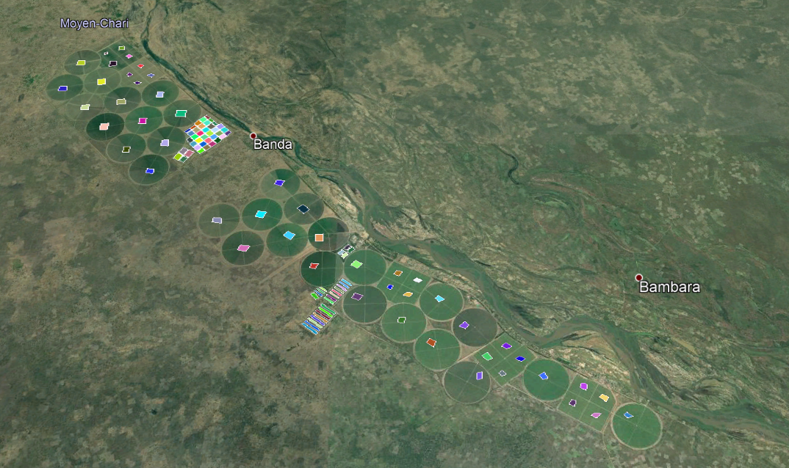

#### *Important: The column name of the shapefile with the training area that contains 1 and 2 has to be 'label'!*

In [50]:
#Define label: property/column name under which the class names (1, 2) are stored in the shapefile ("code")
label = 'code' 

#### *Extract Training Data Pixels*
This step creates the training data set for the RF classifier. For this, all pixels within the polygons for rainfed and irrigated cropland are sampled and stored under the class label 'class' (previously 'label').

In [51]:
#Get training data
training = coeffs.sampleRegions(training_features, [label], scale = 10, tileScale = 4)

#### *Split Training Data*
The training data set is randomly split into data for training (70%) and testing (30%). The training data is used to set up and train the RF model and the test data is used for evaluating the model performance.

In [52]:
sample = training.randomColumn()

In [53]:
split = 0.7

In [54]:
training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))

### *Random Forest Classifier*
---
Set up and train the RF classifier with the training data feature collection (training data, class label, predictors).

In [55]:
#Train the Random Forest Classifier
rndf_trained = ee.Classifier.smileRandomForest(numberOfTrees=30,seed = 10).train(training, label, coeffs.bandNames())

### *Accuracy Measures*
---
Get the accuracy of the RF classifier with training data as well as the accuracy of the classified test data for model evaluation.

In [56]:
#Accuracy of RF classifier with training data
trainAccuracy = rndf_trained.confusionMatrix()

In [57]:
#Classify test data
validated = validation.classify(rndf_trained)

#Accuracy of classification with test data
valid_Accurary = validated.errorMatrix(label, 'classification')

In [58]:
print("Error matrix", valid_Accurary.getInfo());

EEException: Computation timed out.

*Example for Accuracy Matrix with validation data (number of pixels):*

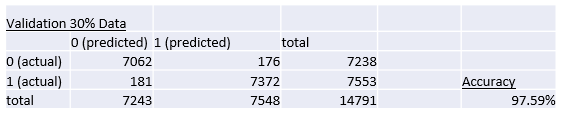

#### *Export both Accuracy Measurements*
Both accuracy measurements are exported to your GoogleDrive. </br>
Check accuracy before classifying and downloading the whole dataset!

In [59]:
export_train_Accuracy = ee.Feature(None, {'matrix': trainAccuracy.array()})

In [61]:
task = ee.batch.Export.table.toDrive(
    collection = ee.FeatureCollection(export_train_Accuracy),
    folder = 'GEE',
    description = 'Train_Accuracy',
    fileFormat = 'CSV'
)

In [62]:
task.start()

In [63]:
task.status()

{'state': 'RUNNING',
 'description': 'Train_Accuracy',
 'creation_timestamp_ms': 1715765159341,
 'update_timestamp_ms': 1715765163853,
 'start_timestamp_ms': 1715765163778,
 'task_type': 'EXPORT_FEATURES',
 'attempt': 1,
 'id': '6HMJHXFEVGL3ZTO55JK4JXRO',
 'name': 'projects/earthengine-legacy/operations/6HMJHXFEVGL3ZTO55JK4JXRO'}

In [64]:
export_valid_Accuracy = ee.Feature(None, {'matrix': valid_Accurary.array()})

In [65]:
task = ee.batch.Export.table.toDrive(
    collection = ee.FeatureCollection(export_valid_Accuracy),
    folder = 'GEE',
    description = 'Valid_Accuracy',
    fileFormat = 'CSV'
)

In [66]:
task.start()

In [67]:
task.status()

{'state': 'RUNNING',
 'description': 'Valid_Accuracy',
 'creation_timestamp_ms': 1715765681289,
 'update_timestamp_ms': 1715765684878,
 'start_timestamp_ms': 1715765684803,
 'task_type': 'EXPORT_FEATURES',
 'attempt': 1,
 'id': 'T3UKLX6PL6H5DOC6SHNIV6YG',
 'name': 'projects/earthengine-legacy/operations/T3UKLX6PL6H5DOC6SHNIV6YG'}

---
### *Farming Systems Classification* 
---
The farming systems are classified based on the harmonic NDVI coefficients, the median ET and the maximum LST with the Random Forest Classifier.

In [99]:
#Apply the Random Forest Classifier to the whole harmonics image and classify Farming Systems
farming_systems = coeffs.classify(rndf_trained)

---
### *Post-Processing*
---
For post-processing of the farming systems classification results, the map is masked with a cropland mask, a mask for the protected areas and a mask for flat areas (slope < 5%). Additionally, a majority filter is applied to create a smoother classification result.

#### *Flat Areas Mask*
The mask was created in QGIS and is used to identify areas that have a slope >5%. All pixels within these areas are reclassified as rainfed, as irrigation is predominantly practiced in flat areas. </br>
Important: The flat areas mask needs to be uploaded to your GEE assets beforehand!

In [100]:
# Import the mask from GEE
flatAreas_mask = ee.Image('projects/ee-mschwarz/assets/flat_area_mask')

In [101]:
# Apply the mask for farming systems
farming_systems = farming_systems.where(flatAreas_mask.eq(1), 2)

#### *Cropland Mask*
Import the cropland mask from your GEE assets and mask out all areas where no agriculture is practiced.</br>
Important: The cropland mask has to be uploaded to your GEE assets beforehand!

In [102]:
#Read Raster file with Cropland Mask
cropland_mask = ee.Image('projects/ee-mschwarz/assets/dea_cropland_extent_kenya_2019')

In [103]:
# Image only containing zeros
zeroImage = ee.Image.constant(0).clip(roi)

# Update mask to fill holes
filledMask = cropland_mask.mask(cropland_mask).unmask(zeroImage)

In [104]:
# Mask out all pixels that are not cropland
#Set pixels that are not cropland (mask = 0) to 0
farming_systems = farming_systems.where(filledMask.eq(0), 0)

#### *Protected Areas Mask*

Protected areas were derived from the World Database on Protected Areas (WDPA), which is the most up-to-date and complete source of information on protected areass, updated monthly with submissions from governments, NGO's, landowners, and communities. It is managed by the United Nations Environment Programme's World Conservation Monitoring Centre (UNEP-WCMC) with support from IUCN and its World Commission on Protected Areas (WCPA).

Source: https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons

In [105]:
# Import dataset with protected areas from GEE
protectedAreas_col = ee.FeatureCollection('WCMC/WDPA/current/polygons')\
    .select('IUCN_CAT', 'REP_AREA')\
    .filterBounds(roi)

# Filter protected areas (exclude zones where agriculture is practiced)
protectedAreas_filtered = protectedAreas_col.filter(ee.Filter.neq('IUCN_CAT', 'VI'))

# Convert feature collection to image
protectedAreas_img = ee.Image().float().paint(protectedAreas_filtered, 'REP_AREA').clip(roi)

In [106]:
# Mask for protected areas
protectedAreasMask = ee.Image(0).clip(roi).where(protectedAreas_img, 1)

In [107]:
# Appply the mask to farming systems
farming_systems = farming_systems.where(protectedAreasMask.eq(1), 0)

#### *Majority Filter*
The majority filter is applied to re-samples the pixels in the farming systems classification according to the majority value of the neighbor cells. This helps to create a smoother classification result.

In [108]:
# Define the size of the majority filter 
filter_size = 3

# Apply the filter by using the neighborhood algorithm
farming_systems = farming_systems.reduceNeighborhood(
    reducer = ee.Reducer.mode(),
    kernel = ee.Kernel.square(filter_size, 'pixels'))

---
### Export Data to Google Drive and Download it
---

#### *Prepare Grid*

In [109]:
#Clip grid to ROI
grid_roi = grid.filterBounds(roi)

In [110]:
#Get original grid size (number of tiles)
grid.size().getInfo()

35

In [111]:
#Get grid size of clipped grid (number of tiles)
grid_roi.size().getInfo()

27

#### *Connect with your Google Drive*
Important: The permissions must be given in your Google Drive-Settings! </br> [Tutorial part 1](https://towardsdatascience.com/how-to-manage-files-in-google-drive-with-python-d26471d91ecd), [Tutorial part 2](https://medium.com/@chingjunetao/simple-way-to-access-to-google-service-api-a22f4251bb52)

In [81]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [82]:
gauth = GoogleAuth()

In [83]:
gauth.LocalWebserverAuth()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=85422423054-vcr213d5kooblqtkj90dd08712uj70md.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [84]:
drive = GoogleDrive(gauth)

#### *Export and Download Farming Systems*
The classified farming systems are exported from GEE to your Google Drive folder and then downloaded to your local computer/server. Once the files are downloaded, the script automatically deletes the respective files in your Google Drive to prevent storage issues.

In [ ]:
for i in range(grid_roi.size().getInfo()): #grid_roi.size().getInfo() -> number of features
    #Select current grid cell
    feature_i = ee.Feature(grid_roi.toList(grid_roi.size().getInfo()).get(i))
    
    #Clip output to grid cell extent
    farming_systems_i = farming_systems.clip(feature_i)
    
    #write current cell to drive
    boundary = feature_i.geometry().bounds().getInfo()['coordinates']
    
    task = ee.batch.Export.image.toDrive(image = farming_systems_i,
                                        region = boundary,
                                        folder = 'GEE',
                                        fileNamePrefix = "Farming_Systems_%d" % i,
                                        fileFormat = 'GeoTIFF', 
                                        crs = 'EPSG:4326',
                                        scale = 10,
                                        maxPixels = 1e10)
    
    task.start()
    
    import time
    for j in range(48):
        if task.status()['state'] == 'COMPLETED':
            #download file from drive folder and delete it afterwards
            #Get list of folders and files of the google drive parent directory
            file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
            file_id = []
            file_name = []
            for file1 in file_list:
                file_id.append(file1['id'])
                file_name.append(file1['title'])
                
            #Write folder id for gee results in new variable
            kenya_id = (file_id[file_name == 'Kenya'])  
                
            #Get list of all files in gee results folder for download
            kenya_file_list = drive.ListFile({'q': "'%s' in parents and trashed = false" % kenya_id}).GetList()
            for file2 in kenya_file_list:
                file2.GetContentFile(r'C:\Documents\Download\%s' % file2['title'], mimetype = file2['mimeType'])
                file2.Delete()
            
            #Break out of for loop after file download
            break
            
        else:
            time.sleep(60*10)
            print(f'Running loop {i+1}: {j+1}')

*Example of final classified Farming Systems (already processed with cropland mask):*

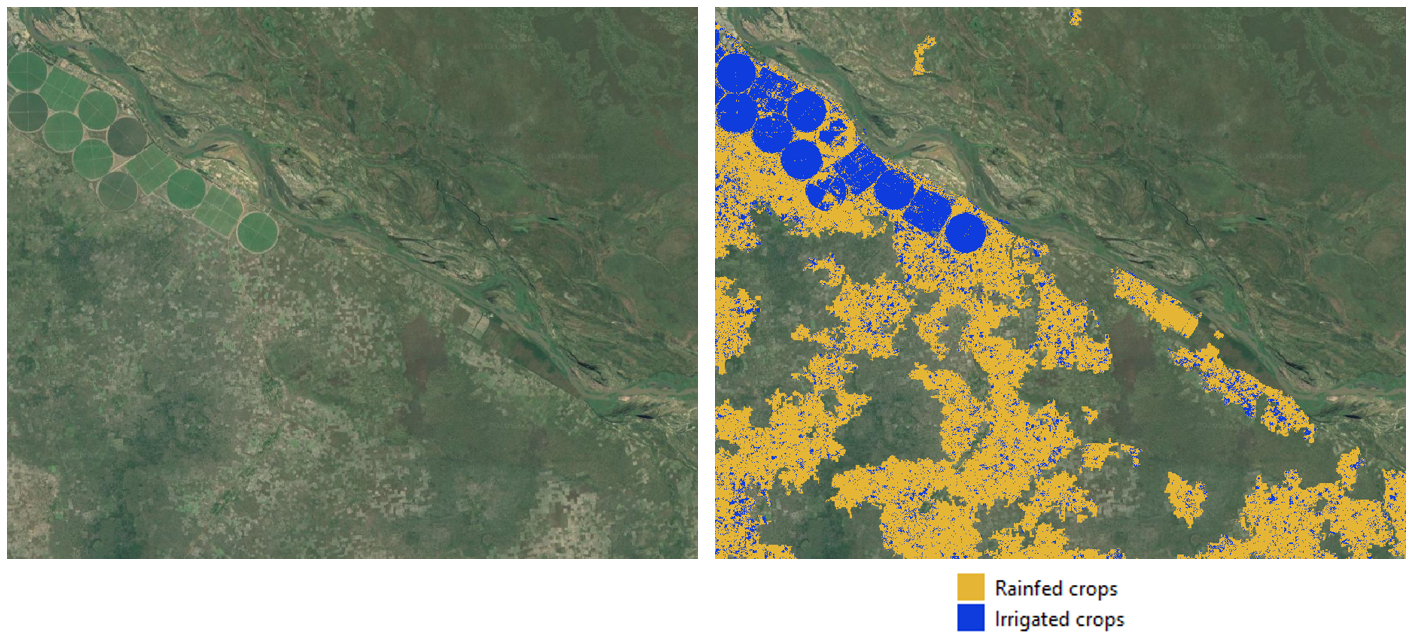